In [1]:
import numpy as np 
import matplotlib.pyplot as plt 
import  nangs 
import  torch
#import cv2
import io

device = "cuda" if torch.cuda.is_available() else "cpu"

nangs.__version__, torch.__version__

('2021.12.06', '1.11.0+cpu')

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

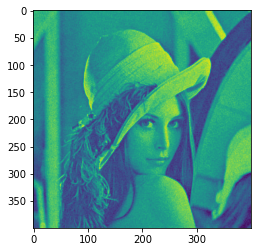

In [3]:
import  matplotlib
image_test = matplotlib.image.imread('D:\\escuela\\WPy64-31040\\hope.jpg')
plt.imshow(image_test)


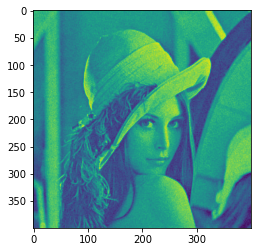

In [4]:
import  matplotlib
image_test = matplotlib.image.imread('D:\\escuela\\WPy64-31040\\hope.jpg')
plt.imshow(image_test)


[[174 168 166 ... 177 173 150]
 [177 170 165 ... 182 163 125]
 [183 175 169 ... 183 167 129]
 ...
 [ 62  62  61 ...  64  67  63]
 [ 49  59  66 ...  71  77  68]
 [ 50  52  66 ...  75  83  68]]
(200, 200)
uint8


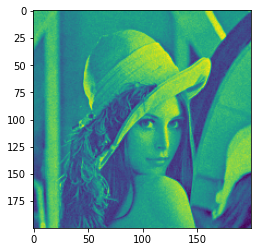

In [5]:
import cv2
img=cv2.imread("D:\\escuela\\WPy64-31040\\hope.jpg", cv2.IMREAD_GRAYSCALE)
print(img)

dim = (200, 200)
  
# resize image
initial_img = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
# initial_img = cv2.resize(poisson_noise, dim, interpolation = cv2.INTER_AREA)

#io.imsave("initial_image.jpg", initial_img)
print(initial_img.shape)
print(initial_img.dtype)

plt.imshow(initial_img)

In [6]:
from nangs import PDE
import math

K=50

class PeronaMalik(PDE):
    def computePDELoss(self, inputs, outputs):
                
        # compute gradients
        
        # compute first-order derivatives
        grads = self.computeGrads(outputs, inputs)
        dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        
        # compute second-order derivatives
        dp2dx2 = self.computeGrads(dpdx, inputs)[:, 0]        
        dp2dy2 = self.computeGrads(dpdy, inputs)[:, 1]
        #dudas
        dp2dpxdpy=self.computeGrads(dpdx, inputs)[:, 1]
        dp2dpydpx=self.computeGrads(dpdy, inputs)[:, 0]
        
        
        # compute loss
        #dpdx, dpdy, dpdt = grads[:, 0], grads[:, 1], grads[:, 2]
        return {'pde': dpdx*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dx2)+(dpdy*dp2dpydpx))
                      -dpdy*(-2/K**2)*torch.exp(-(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2)  *((dpdx*dp2dpxdpy)+(dpdy*dp2dy2))
               +torch.exp(  -(    torch.pow(dpdx,2)+torch.pow(dpdy,2))/K**2) * ( dp2dx2+dp2dy2 )-dpdt}
    
pde = PeronaMalik(inputs=('x', 'y', 't'), outputs='p')

In [7]:
import torch
import random


class BaseSampler():
    def __init__(self, data, n_samples=1, device="cpu"):
        assert isinstance(data, dict), "you must pass a dict with your data"
        self.device = device
        self.data = data
        self.vars = tuple(data.keys())
        self.n_samples = n_samples

    def _sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        sample = self.sample(n_samples)
        return torch.stack([
            sample[var]
            for var in self.vars
        ], axis=-1)

    def sample(self, n_samples=None):
        raise ValueError("you must implement this method")
    
    



class Perona_Sampler(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<-1:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        
        #if random.randint(0,100)<=1:
            #print(result)
        return result
    
    
class Perona_Sampler_Ini(BaseSampler):
    def __init__(self, data, n_samples=1, device="cpu"):
        super().__init__(data, n_samples, device)
        for var, lims in data.items():
            if isinstance(lims, list):
                assert len(
                    lims) == 2, "you must pass a list with the min and max limits"
            elif isinstance(lims, int) or isinstance(lims, float):
                data[var] = [lims, lims]
            else:
                raise ValueError("invalid limits")

    def sample(self, n_samples=None):
        n_samples = n_samples or self.n_samples
        a={
            
            var: torch.rand(n_samples, device=self.device) *
            (lims[1] - lims[0]) + lims[0]
            for var, lims in self.data.items()
        }
        i=0
        b_list=[]
        for item in range(n_samples):
            b=random.uniform(0,200)
            if i<n_samples/10:
                b_list.append(0)
            else:
                b_list.append(b)
            i+=1
            #print(i,b)
            
        
        b_tensor=torch.tensor(b_list,device=self.device)
        #for i in b_tensor:
        #    b_tensor[i]=b
        result={'x':a['x'],'y':a['y'],'t':b_tensor}  
        #print(result)
        return result


In [8]:
n_samples = 80000
print("a")

a


In [9]:
# define the sampler

from nangs import RandomSampler

sampler = Perona_Sampler({
    'x': [0., 200.], 
    'y': [0., 200.],
    't': [0., 200.], 
}, device=device, n_samples=1000)

pde.set_sampler(sampler)
print("a")

a


In [10]:


def initial_condition_Adr(x,y):
    res = torch.zeros(len(x))
    for i in range(len(x)):
        if len(x) == 1:
            res[i] = initial_img[int(x.item()),int(y.item())]
        else:
            res[i]=(initial_img [int(x[i]),int(y[i])])
        #print(res)
    #print("hey")
    #print(res)        
    return res

In [11]:
def cero_f(x,y):
    res = torch.zeros(len(x))
    for i in range(0,len(x)):
        res[i]=0
    return res

In [12]:
def cero_f(n_samples):
    return torch.zeros(n_samples)

In [13]:
def f_circle(x,y):
    z = (x - 100)**2 + (y - 100)**2
    for i in range(0,len(z)):
        if z[i] <= 800:
            z[i] = 30
        else: z[i] = 200

    return z

In [14]:
def cart_prod(*args):
    grids =np.meshgrid(*args,indexing='ij')
    return np.stack(grids,axis=-1).reshape(-1,len(args))

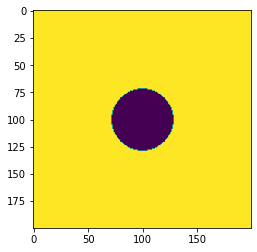

In [15]:
x = np.linspace(0,199,200)

grid=cart_prod(x,x)


xs, ys= grid[:, 0:1], grid[:,1:2]
ini_circle=f_circle(xs,ys).reshape(200,200)

plt.imshow(ini_circle)


In [16]:
from nangs import Dirichlet



foto = Dirichlet(
    Perona_Sampler_Ini({'x': [0., 200.], 'y': [0., 200.],'t':0}, device=device, n_samples=n_samples), 
     lambda inputs: {'p' :f_circle(inputs['x'],inputs['y'])},
    name="foto"
)
#print(temp)
                           
pde.add_boco(foto)
print("a")

a


In [17]:
import torch


class Sine(torch.nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, x):
        return torch.sin(x)


def block(i, o):
    fc = torch.nn.Linear(i, o)
    return torch.nn.Sequential(
        Sine(),
        torch.nn.Linear(i, o)
    )


class MLP(torch.nn.Module):
    def __init__(self, inputs, outputs, layers, neurons):
        super().__init__()
        
        fc_in = torch.nn.Linear(inputs, neurons)
        fc_hidden = [
            block(neurons, neurons)
            for layer in range(layers-1)
        ]
        fc_out = block(neurons, outputs)

        self.mlp = torch.nn.Sequential(
            fc_in,
            *fc_hidden,
            fc_out
        )

    def forward(self, x):
        return self.mlp(x)
    
    #def anzatc(self, u, xs):
    #    """ Anzatc-transformation of the model-output needed for binding initial and boundary conditions. """
    #    # Get tensor of spatial variables and time-tensor.
    #    xs_spatial = xs[:, :self.ndims_spatial]
    #    t = xs[:, self.ndims - 1:self.ndims]
    #    lower, upper = [lims[0] for lims in self.domain], [lims[1] for lims in self.domain]
    #    lower_spatial, upper_spatial = [torch.Tensor(lst[:self.ndims_spatial]).reshape(1, -1).float()
    #                                    for lst in (lower, upper)]
    #    t0 = lower[-1]

        # Apply transformation to bind the boundary condition.
    #    if self.boundary_condition is not None:
    #        u = (u * (torch.prod((xs_spatial - lower_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True) *
    #                  torch.prod((upper_spatial - xs_spatial) / (upper_spatial - lower_spatial), dim=1, keepdim=True))
    #                 + self.boundary_condition)

        # Apply transformation to bind the initial condition.
    #    if self.initial_condition is not None:
    #        _xs_spatial = [xs_spatial[:, i] for i in range(xs_spatial.shape[1])]
    #        u = ((nn.Sigmoid()((t - t0) / torch.exp(self.log_scale)) - .5) * u
    #             + self.initial_condition(*_xs_spatial).view(-1, 1))
    #    return u

In [18]:
# solve

#from nangs import MLP

LR = 1e-2
N_STEPS = 800
NUM_LAYERS = 3
NUM_HIDDEN = 128
print(len(pde.inputs))
print(len(pde.outputs))

for item in pde.inputs:
    print(item)
for item in pde.outputs:
    print(item)
    
    
mlp = MLP(len(pde.inputs), len(pde.outputs), NUM_LAYERS, NUM_HIDDEN).to(device)
optimizer = torch.optim.Adam(mlp.parameters())
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=LR, pct_start=0.1, div_factor=10, final_div_factor=1, total_steps=N_STEPS)

pde.compile(mlp, optimizer, scheduler)
%time hist = pde.solve(N_STEPS)

3
1
x
y
t
p


{'pde': 42.16588, 'foto': 1471.70398}: 100%|█████████████████████████████████████████| 800/800 [48:45<00:00,  3.66s/it]

Wall time: 48min 45s


<AxesSubplot:>

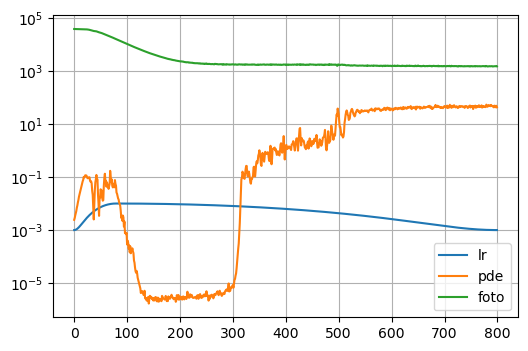

In [19]:
import pandas as pd 

df = pd.DataFrame(hist)
fig = plt.figure(dpi=100)
ax = plt.subplot(1,1,1)
ax.set_yscale('log')
df.plot(ax=ax, grid=True)

(200, 200)
float64


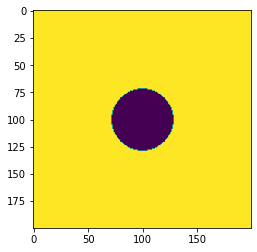

In [20]:
print(ini_circle.shape)
print(ini_circle.dtype)
plt.imshow(ini_circle)


In [87]:
x = np.linspace(0,199,200)
y = np.linspace(0,199,200)
t=0

grid=cart_prod(x,y,t)
xs, ys= grid[:, 0:1], grid[:,1:2]

X = torch.from_numpy(grid).float().to(device)
image_final =  pde.eval(X)

xs, ys= grid[:, 0:1], grid[:,1:2]
print(image_final.shape)
print(image_final.dtype)

#plt.imshow(f_circle(xs,ys).reshape(200,200))

torch.Size([40000, 1])
torch.float32


In [88]:
imashow=image_final.reshape(200,200)

In [89]:
def float_to_int(imashow):
    for i in range(len(imashow)):
        for j in range (len(imashow)):
            imashow[i][j]=int(imashow[i][j])

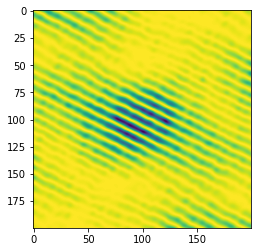

In [90]:
#float_to_int(imashow)
plt.imshow(imashow)

In [81]:
#from skimage import io
#io.imsave(".\\images_perona\\circ_1.7_t50.jpg",imashow)

Lossy conversion from float32 to uint8. Range [133.8984375, 195.42140197753906]. Convert image to uint8 prior to saving to suppress this warning.


In [25]:
for i in range(len(imashow)):
    pass
len(imashow[0])

200

In [26]:
print(imashow)

tensor([[192.2576, 194.6642, 195.3993,  ..., 186.5578, 187.7262, 189.3947],
        [184.2148, 189.0036, 192.8923,  ..., 186.3979, 186.9367, 188.1783],
        [175.7394, 180.9488, 186.1205,  ..., 187.7167, 187.6357, 188.3004],
        ...,
        [192.9789, 193.3622, 193.7717,  ..., 174.2700, 173.3270, 173.7683],
        [192.4186, 192.7365, 193.1525,  ..., 177.4779, 174.8597, 173.5381],
        [192.1701, 192.4275, 192.7898,  ..., 184.3750, 180.7839, 177.8584]])


In [27]:
def matrix_substract(a,b):
    res=np.zeros_like(a)
    for i in range(len(a)):
        for j in range(len(a[0])):
            res[i][j]=abs(abs(a[i][j])-abs(b[i][j]))
            
    return res

In [28]:
sub=matrix_substract(ini_circle,imashow)
sum=0
for i in range(len(sub)):
        for j in range(len(sub[0])):
            sum+=sub[i][j]
print(   sum/  (  len(sub)*len(sub[0])  )   )

18.320256096267702


aca utilizamos el Perona_Sampler_Ini para la condicion inicial  